In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch.optim as optim
import torch

from tqdm import tqdm
from time import time
from pathlib import Path
import os

from dataset import NocsLossDataset
from models.nocs_loss_model import Resnet18LossPred


# Configurations
PROJECT_PATH    = Path('/home/baldeeb/Code/pytorch-NOCS/')
EVAL_DATA_PATH  = PROJECT_PATH / Path( 'data/output/1682892735.3506837')
TRAIN_DATA_PATH = PROJECT_PATH / Path( 'data/output/1682896412.9365406')
CHKPT_PATH      = PROJECT_PATH / Path('checkpoints/losspred/1683137446.7071385/1.pth')
device          = 'cuda:0'

In [7]:
dataset  = NocsLossDataset(EVAL_DATA_PATH)
model = Resnet18LossPred.load(CHKPT_PATH)
model = model.to(device).train() 

In [14]:
import numpy as np
def visualize(img, loss, prefix=''):
    import matplotlib.pyplot as plt
    plt.imshow(img.permute(1,2,0).detach().cpu().numpy())
    plt.title(f'{prefix}\nLoss: {loss.item()}')
    plt.show()

def tensorify(x):
    if isinstance(x, np.float32): return torch.tensor([x]).float().to(device)
    return torch.from_numpy(x).unsqueeze(0).float().to(device)

In [19]:
model.eval()
loss_list, pred_list, gt_list = [], [], []
for img, gt in tqdm(dataset):
    img, gt = tensorify(img), tensorify(gt)
    pred = model(img)
    loss = model.get_loss(img, gt)
    gt_list.append(gt.item())
    loss_list.append(loss.item())
    pred_list.append(pred.item())

100%|██████████| 3360/3360 [00:21<00:00, 158.82it/s]


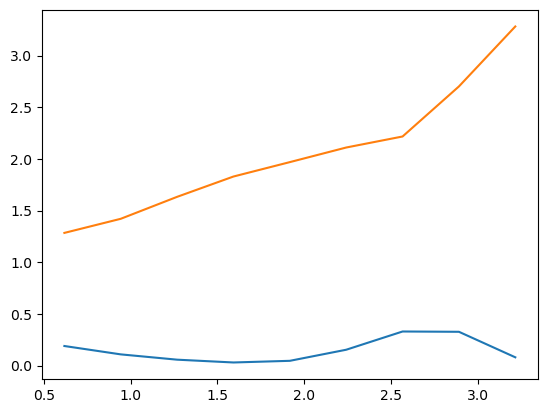

In [20]:
import matplotlib.pyplot as plt

# Get average loss for each gt bin
gt_list = np.array(gt_list)
loss_list = np.array(loss_list)
pred_list = np.array(pred_list)
gt_bins = np.linspace(gt_list.min(), gt_list.max(), 10)

bin_using_gt = lambda x : [x[np.logical_and(gt_list >= gt_bins[i], gt_list < gt_bins[i+1])].mean() 
                           for i in range(len(gt_bins)-1)]

loss_bins = bin_using_gt(loss_list)
pred_bins = bin_using_gt(pred_list)
# loss_bins = []
# for i in range(len(gt_bins)-1):
#     loss_bins.append(loss_list[np.logical_and(gt_list >= gt_bins[i], gt_list < gt_bins[i+1])].mean())
plt.plot(gt_bins[:-1], loss_bins)
plt.plot(gt_bins[:-1], pred_bins)
plt.show()

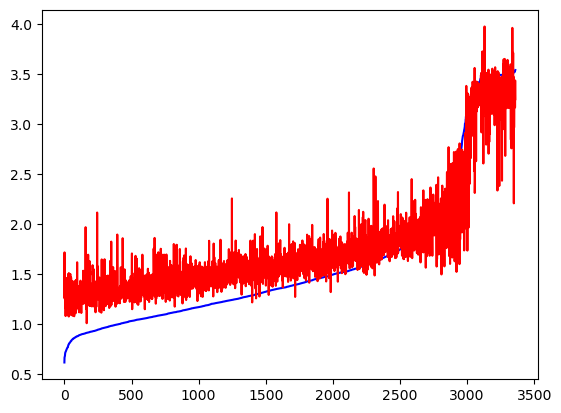

In [21]:
plt.figure()

# get sorged gt values and indices
sorted_indices = np.argsort(gt_list)
gt_list = gt_list[sorted_indices]
loss_list = loss_list[sorted_indices]
pred_list = pred_list[sorted_indices]

plt.plot(gt_list, 'b')
plt.plot(pred_list, 'r')

plt.show()

:(  The model does not seem to learn anything. Loss reduces by simply predicting low loss

Gt loss: 1.6193463802337646


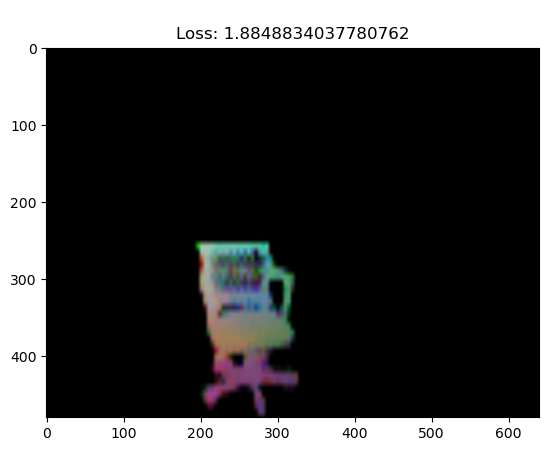

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


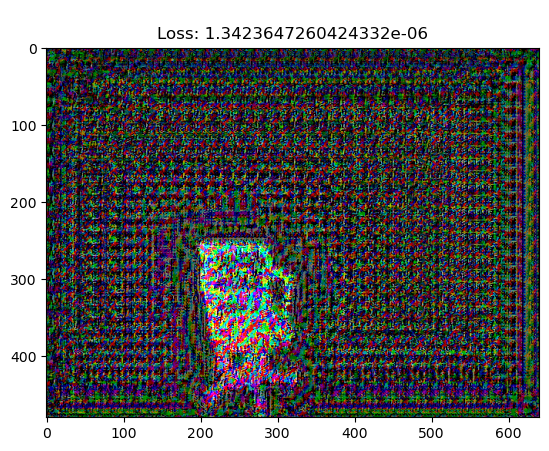

Gt loss: 1.2474550008773804


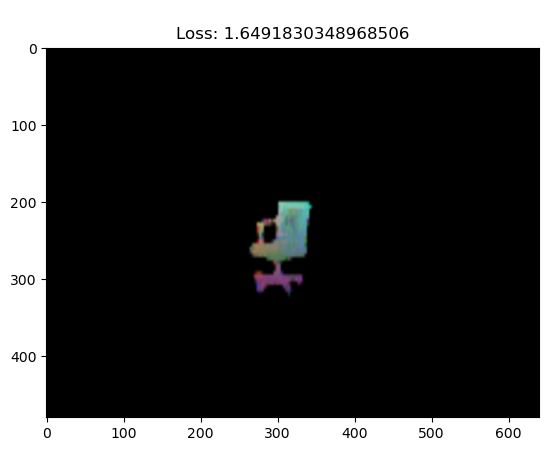

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


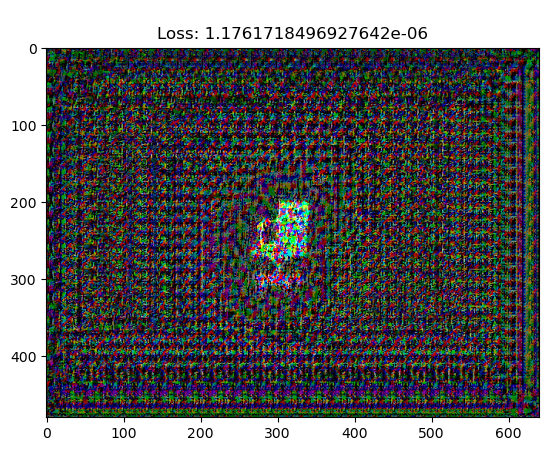

Gt loss: 3.4943439960479736


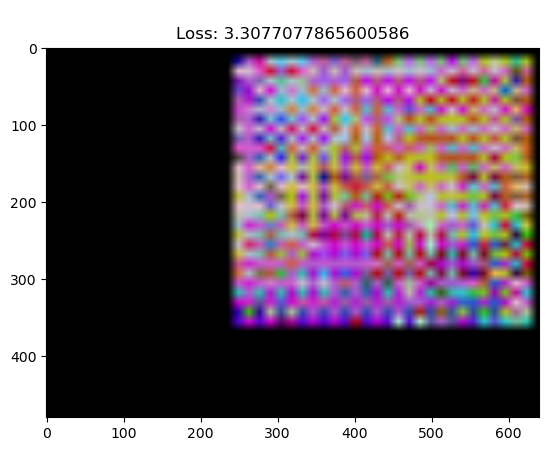

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


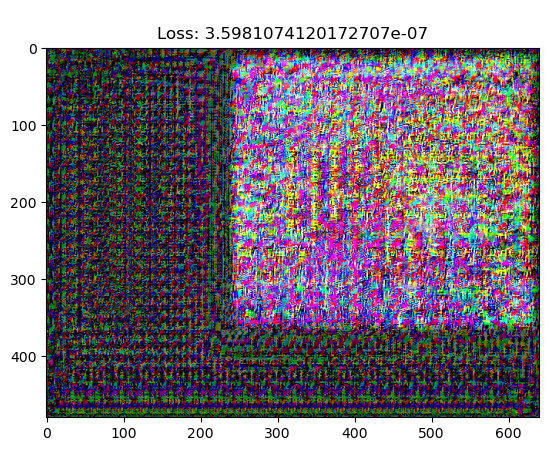

Gt loss: 1.9988809823989868


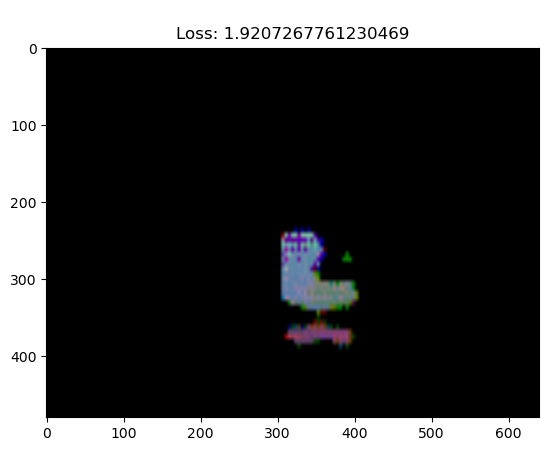

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


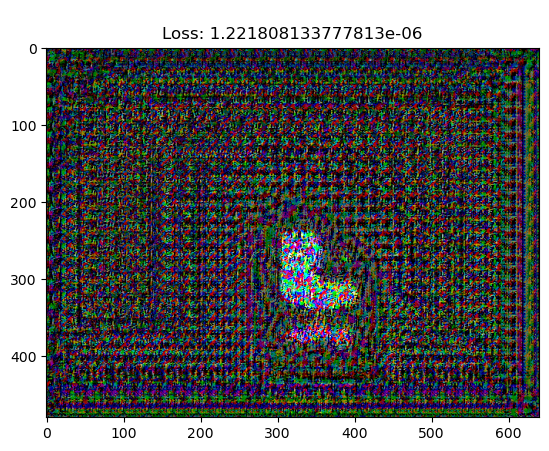

Gt loss: 3.5158674716949463


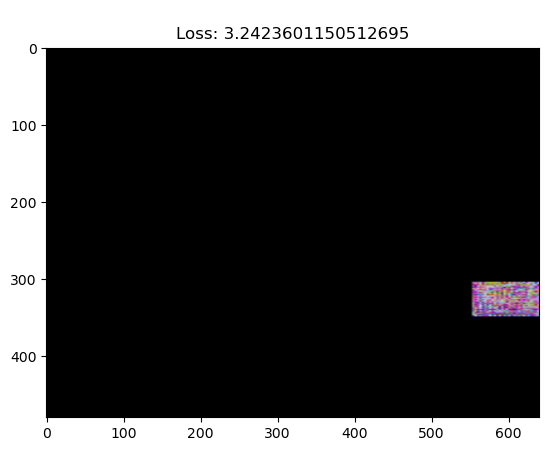

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


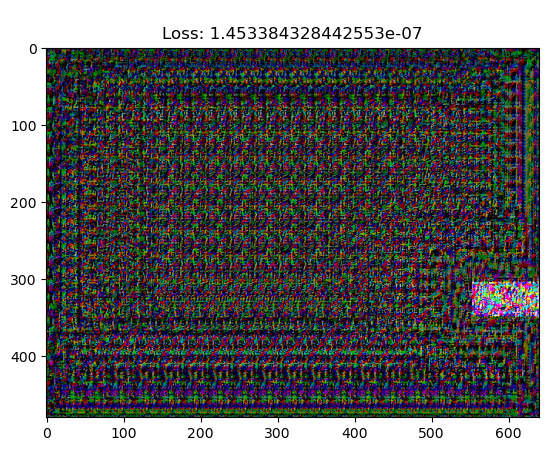

Gt loss: 1.1910287141799927


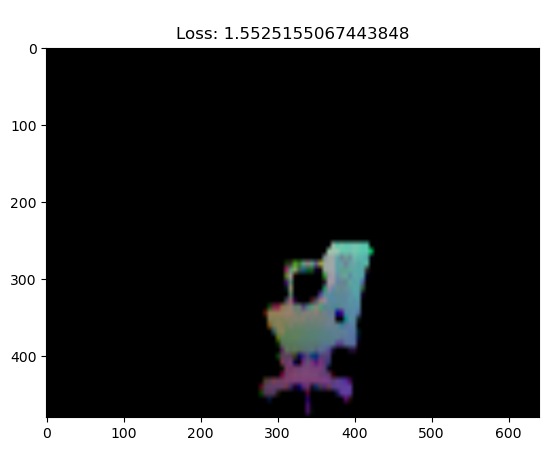

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


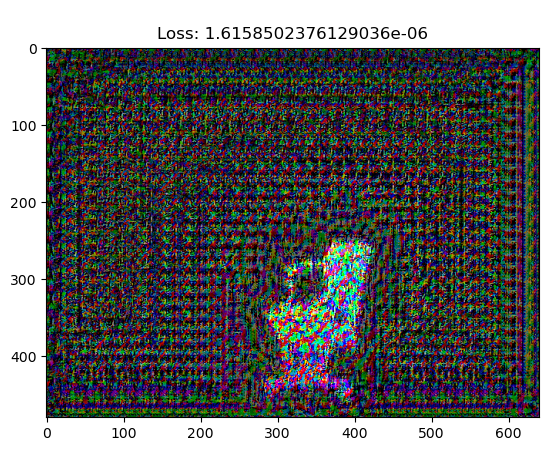

Gt loss: 1.0161699056625366


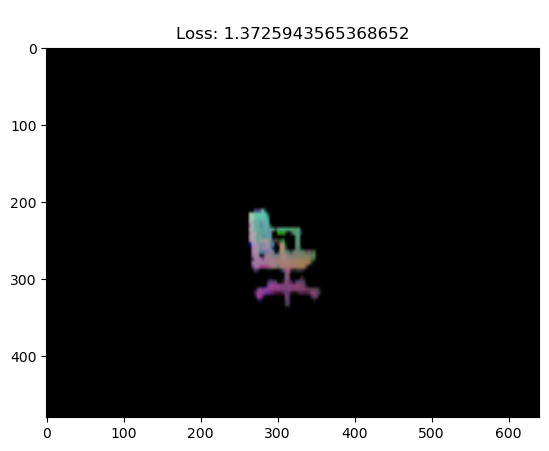

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


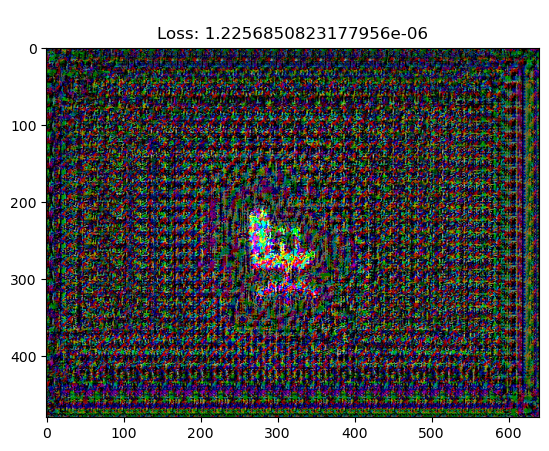

Gt loss: 1.6100889444351196


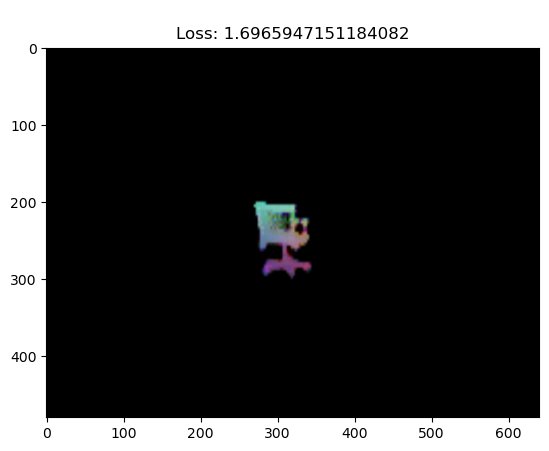

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


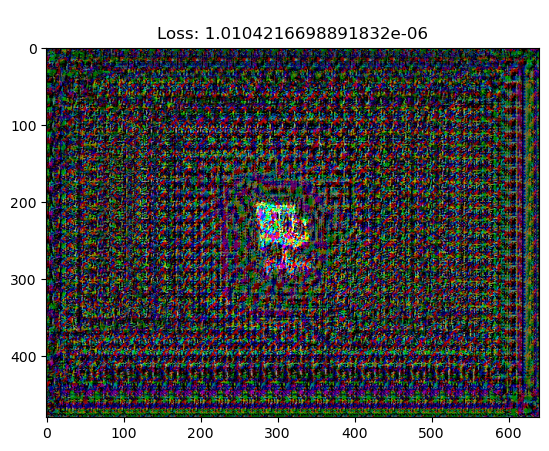

Gt loss: 1.20904541015625


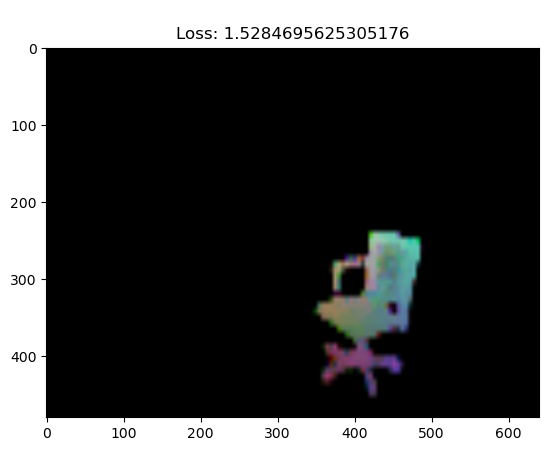

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


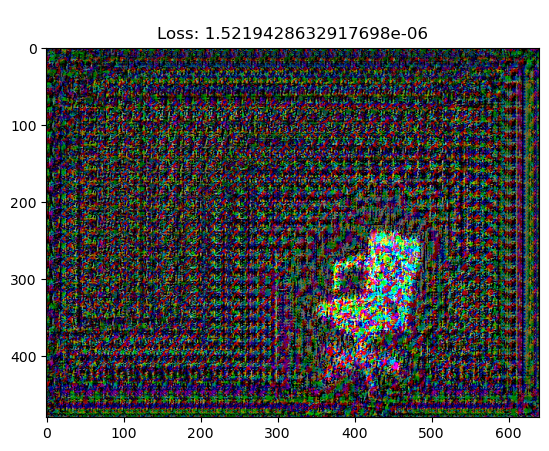

Gt loss: 1.3762078285217285


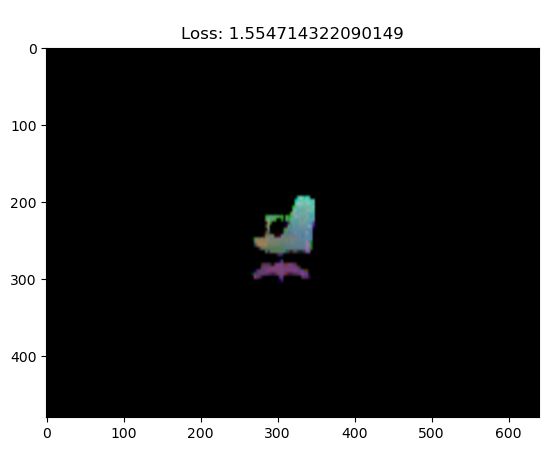

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


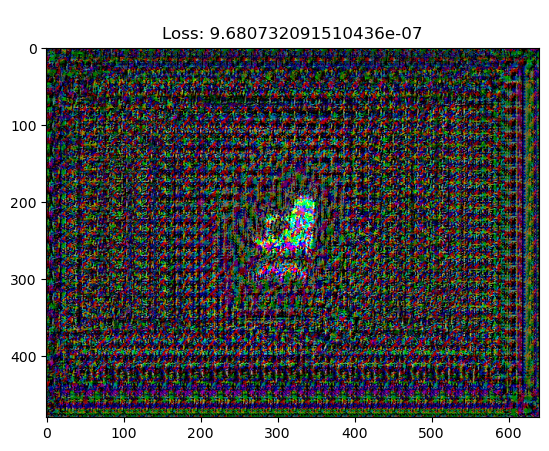

In [24]:
idx_list = np.random.choice(np.arange(len(dataset)), 10)
for idx in idx_list:
    img, gt = dataset[idx]
    img, gt = tensorify(img), tensorify(gt)
    fixed = model.fix(img)
    print(f'Gt loss: {gt[0]}')
    visualize(img[0], model(img))
    visualize(fixed[0], model(fixed))

# Testing box visualization and eval

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
from utils.align import align
from habitat_datagen_util.utils.dataset import HabitatDataset
from habitat_datagen_util.utils.collate_tools import collate_fn
from torch.utils.data import DataLoader
import torch 

dataset  = HabitatDataset('/home/bahaa/Code/torch_nocs/data/habitat-datagen/00847-bCPU9suPUw9')
dataloader = DataLoader(dataset, 
                        batch_size=5, 
                        shuffle=True, 
                        collate_fn=collate_fn)
images, targets = next(dataloader.__iter__())
print(f'targets contain: {targets[0].keys()}')

t = targets[0]
# as_list = lambda k, i=0: [t[k] for t in targets]
# masks = as_list('masks')
# coords, depth

_to_ndarray = lambda a : a.numpy() if isinstance(a, torch.Tensor) else a
m, n, d   = (_to_ndarray(t[k]) for k in ['masks', 'nocs', 'depth'])
intrinsic = _to_ndarray(dataset.intrinsic())
transforms, scales, _ = align(m, n, d, intrinsic)

ValueError: Invalid data location: /home/bahaa/Code/torch_nocs/data/habitat-datagen/00847-bCPU9suPUw9

In [9]:
from utils.visualization import draw_3d_boxes

print(transforms.shape, scales.shape)

img = draw_3d_boxes(_to_ndarray(images[0].permute(1,2,0)), 
                    _to_ndarray(transforms[0]), 
                    _to_ndarray(scales[0]), 
                    _to_ndarray(intrinsic))

(1, 4, 4) (1, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


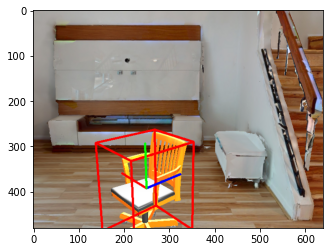

In [10]:
import matplotlib.pyplot as plt

plt.imshow(img)

# Evaluation 
Check 
 - https://torchmetrics.readthedocs.io/en/v0.11.4/detection/mean_average_precision.html
 - https://pytorch3d.org/docs/iou3d
 - https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/ops/iou_box3d.py
 - https://github.com/hughw19/NOCS_CVPR2019/blob/master/utils.py#L1662 

# Testing the inference wrapper

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Initialize detector
from inference_wrapper import NocsDetector

K = [[591.0125, 0,          322.525], 
    [0,         590.16775,  244.11084], 
    [0,         0,          1]]
chkpt = './checkpoints/nocs_classification/2023-05-19_14-40-16/run_with_curated_data_4.pth'
det = NocsDetector(chkpt, K, return_annotated_image=True)

# Get some data
from habitat_datagen_util.utils.dataset import HabitatDataset
from habitat_datagen_util.utils.collate_tools import collate_fn
from torch.utils.data import DataLoader

dataset  = HabitatDataset('./data/habitat/generated/curated_2023_05_19_02_00/test')
dataloader = DataLoader(dataset, 
                        batch_size=5, 
                        shuffle=True, 
                        collate_fn=collate_fn)
images, targets = next(dataloader.__iter__())
print(f'targets contain: {targets[0].keys()}')

targets contain: dict_keys(['depth', 'masks', 'nocs', 'labels', 'boxes'])


In [9]:
import torch
depth = torch.stack([t['depth'] for t in targets])
r = det(images, depth)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['boxes', 'labels', 'scores', 'masks', 'nocs', 'transforms', 'scales', 'annotated_image'])


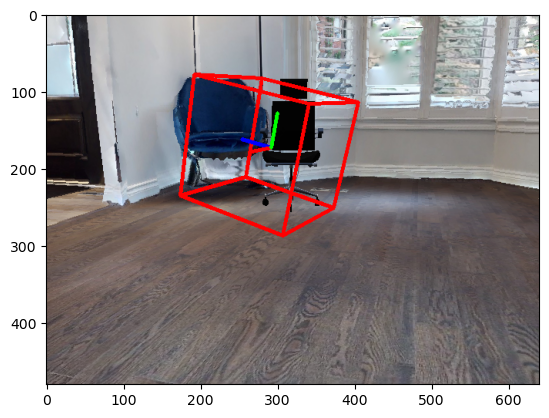

In [10]:
import matplotlib.pyplot as plt

print(r[0].keys())

plt.imshow(r[0]['annotated_image'])